In [2]:
import numpy as np
import cv2
import PIL
import math
import imutils
import os
import matplotlib.pyplot as plt
import random
import torch

In [3]:
!pip install segment-anything

In [4]:
SAM_CHKPT_PATH = '/content/drive/MyDrive/sam_vit_b_01ec64.pth'

In [5]:
import torch
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

model_type = 'vit_b'
sam = sam_model_registry[model_type](checkpoint=SAM_CHKPT_PATH)
sam.to(device=device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [6]:
init_mask_gen = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side = 16,
    pred_iou_thresh = 0.8,
    stability_score_thresh=0.8,
    crop_n_layers=0,
    min_mask_region_area=1800,
    crop_n_points_downscale_factor=2
)
ind_cell_mask_gen = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side = 16,
    pred_iou_thresh = 0.88,
    stability_score_thresh=0.88,
    crop_n_layers=0,
    min_mask_region_area=1800,
    crop_n_points_downscale_factor=2
)

In [7]:
import cv2
import imutils
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

def load_images(IMG_FILE_PATH):
    images = []
    for filename in os.listdir(IMG_FILE_PATH):
        img = cv2.imread(os.path.join(IMG_FILE_PATH,filename))
        if img is not None:
            images.append(img)
    return images



In [8]:
def preprocess_image_low_cont(image):
    torch.set_default_dtype(torch.float32)
    plt.imshow(image)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayscale,150,25)
    # edges = cv2.erode(edges, kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3)), iterations=1)

    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()
    edges_3d_array = np.zeros((1080, 1080, 3))
    for i in range(3):
        edges_3d_array[:, :, i] = edges

    edges_3d_array = cv2.GaussianBlur(edges_3d_array, (3, 3), 0)
    plt.imshow(edges_3d_array)

    plt.show()
    return edges_3d_array


get edge crops from all rois and pass them to process clusters function

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x:x['area']), reverse=True)
    ax = plt.gca()
    # ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def generate_mask(image, generator):

    masks = generator.generate(np.asarray(image, dtype='uint8'))
    return masks

def show_mask(image, masks):
    print('No of detected cells = ', len(masks))
    plt.figure(figsize=(8, 5))
    plt.imshow(image)
    show_anns(masks)
    plt.axis('off')
    plt.show()

def separate_clusters(masks, raw, edge_image):

    individual_cells = []
    clusters = []
    cropped_rois = []
    cluster_rois = []

    for i in range(len(masks)):
        x=int(masks[i]['bbox'][0])
        y=int(masks[i]['bbox'][1])
        a=int(masks[i]['bbox'][2])
        b=int(masks[i]['bbox'][3])
        cropped_im = np.array(raw[y:y+b, x:x+a, :])
        edge_im_crop = np.array(edge_image[y:y+b, x:x+a, :])
        cropped_rois.append(cropped_im)
        cropped_mask = masks[i]['segmentation'][y:y+b, x:x+a]
        # if a > 90 | b > 90:
        #   continue
        area = masks[i]['area']
        cropped_im[cropped_mask==False] = [0, 0, 0]
        if area in range(2000, 3000):
          # if masks[i]['predicted_iou'] < 1 and masks[i]['predicted_iou'] >= 0.92:
            individual_cells.append(cropped_im)
            plt.subplot(121)
            plt.title('cropped image (single cell)')
            plt.imshow(cropped_im)
            plt.subplot(122)
            plt.imshow(cropped_mask)
            plt.show()
            print('Predicted IoU: ', masks[i]['predicted_iou'])
            print('Stability score: ', masks[i]['stability_score'])
            # print('crop box: ', masks[i]['crop_box'], 'Bounding box: ', masks[i]['bbox'])
            # print('Point Coordinates: ', masks[i]['point_coords'])
        elif area > 3100:
            clusters.append(edge_im_crop)
            cluster_rois.append(cropped_im)
        else:
            continue
    return individual_cells, clusters, cluster_rois

def process_cluster(cluster_edges, cluster_rois):
    print('processing cluster...')
    individual_cells = []

    for k in range(len(cluster_edges)):

        mask_cluster = generate_mask(np.asarray(cluster_edges[k], dtype='uint8'), ind_cell_mask_gen)
        show_mask(cluster_edges[k], mask_cluster)
        for j in range(len(mask_cluster)):
            x=int(mask_cluster[j]['bbox'][0])
            y=int(mask_cluster[j]['bbox'][1])
            a=int(mask_cluster[j]['bbox'][2])
            b=int(mask_cluster[j]['bbox'][3])
            cropped_im = np.array(cluster_rois[k][y:y+b, x:x+a, :])
            area = b*a
            cropped_im[mask_cluster==False] = [0, 0, 0]
            if area in range(1000, 3000):
              # if mask_cluster[j]['predicted_iou'] < 1 and mask_cluster[j]['predicted_iou'] >= 0.9:
                individual_cells.append(cropped_im)
                plt.imshow(cropped_im)
                plt.show()
                print('Predicted IoU: ', mask_cluster[j]['predicted_iou'])
                print('Stability score: ', mask_cluster[j]['stability_score'])
                # print('crop box: ', mask_cluster[j]['crop_box'], 'Bounding box: ', mask_cluster[j]['bbox'])
                # print('Point Coordinates: ', mask_cluster[j]['point_coords'])
                # print('added to individual cells array....')

    return individual_cells



In [10]:
def preprocess_image_high_cont(image):

    plt.imshow(image)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # first isolate blue spores
    result = image.copy()
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])

    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])

    lower_mask = cv2.inRange(hsv, lower1, upper1)
    upper_mask = cv2.inRange(hsv, lower2, upper2)

    full_mask = lower_mask + upper_mask

    result_blue = cv2.bitwise_and(result, result, mask = lower_mask)

    # next isolate red spores
    lower_blue = np.array([100, 100, 20])
    upper_blue = np.array([140, 255, 255])

    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    result_red = cv2.bitwise_and(image, image, mask = mask_blue)
    spores = result_red + result_blue

    # next isolate pink spores
    lower_pink = np.array([100, 100, 20])
    upper_pink = np.array([140, 255, 255])

    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    result_red = cv2.bitwise_and(image, image, mask = mask_blue)

    # now do thresholding on total spore image
    spores_grayscale = cv2.cvtColor(cv2.cvtColor(spores, cv2.COLOR_BGR2HSV), cv2.COLOR_BGR2GRAY)

    th = cv2.adaptiveThreshold(spores_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

    erosion = np.array(
        [
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1 ,1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]
        ]
      )

    for erode_iter in range(0, 3):
        thick_bounds = cv2.erode(cv2.dilate(th, kernel=erosion, iterations= 1), kernel=erosion, iterations= 1)

    # th = cv2.dilate(thick_bounds, kernel = erosion, iterations = 1)

    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(th,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()
    edges_3d_array = np.zeros((1080, 1080, 3))
    for i in range(3):
        edges_3d_array[:, :, i] = thick_bounds

    # edges_3d_array = cv2.GaussianBlur(edges_3d_array, (3, 3), 0)
    plt.imshow(edges_3d_array)

    plt.show()
    return edges_3d_array

<ipython-input-10-679f6fc74c0a>:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121),plt.imshow(image,cmap = 'gray')


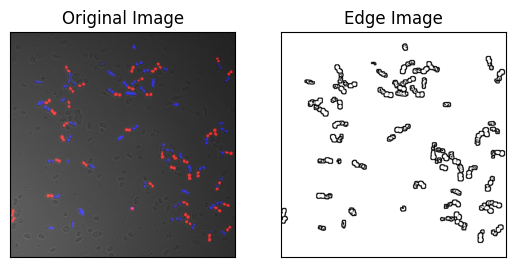

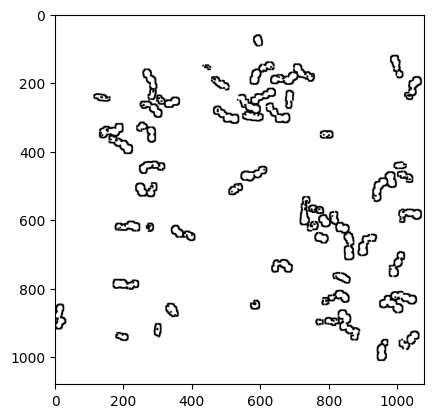

No of detected cells =  35


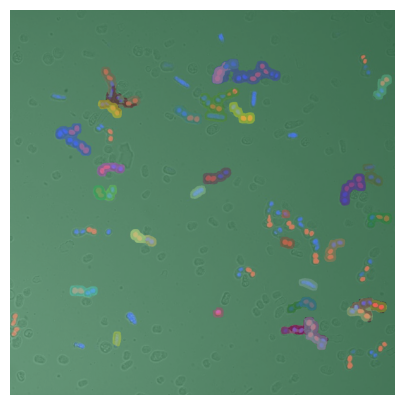

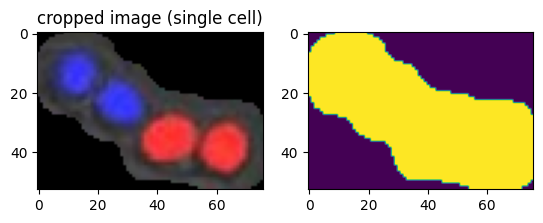

Predicted IoU:  0.950318455696106
Stability score:  0.980737030506134


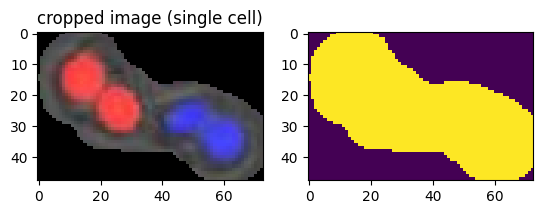

Predicted IoU:  0.9484674334526062
Stability score:  0.9634615182876587


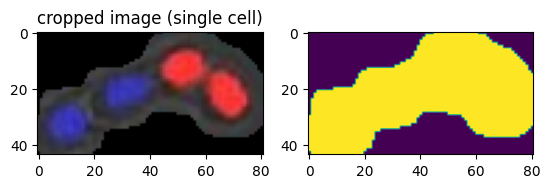

Predicted IoU:  0.9346184134483337
Stability score:  0.9809734225273132


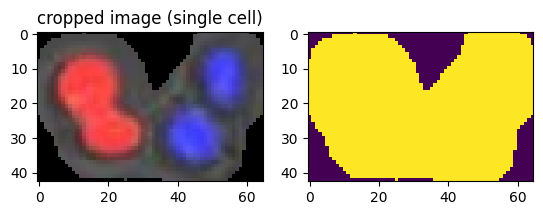

Predicted IoU:  0.929240882396698
Stability score:  0.9687368273735046


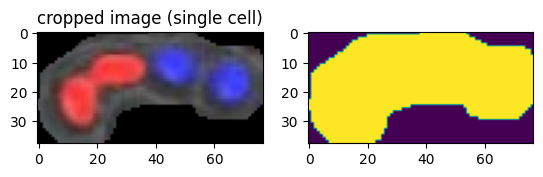

Predicted IoU:  0.9104697704315186
Stability score:  0.9828734397888184


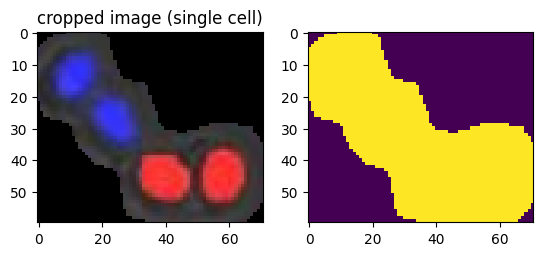

Predicted IoU:  0.9470138549804688
Stability score:  0.9477096199989319


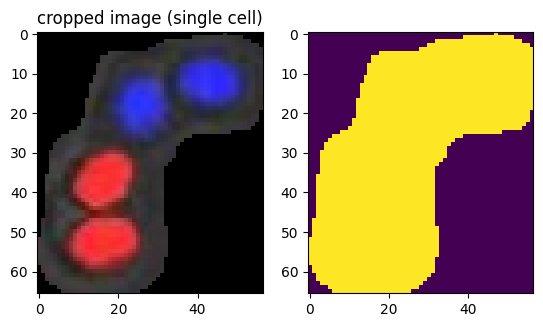

Predicted IoU:  0.9418797492980957
Stability score:  0.9637007713317871


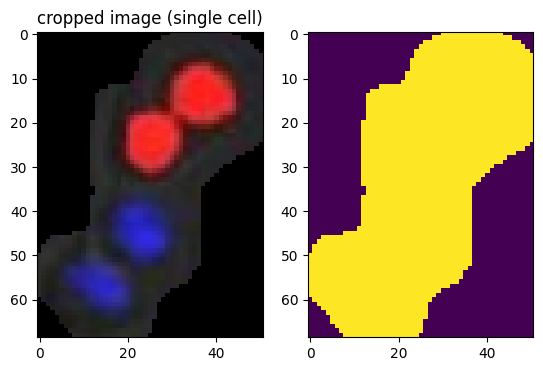

Predicted IoU:  0.9391105771064758
Stability score:  0.8828600645065308


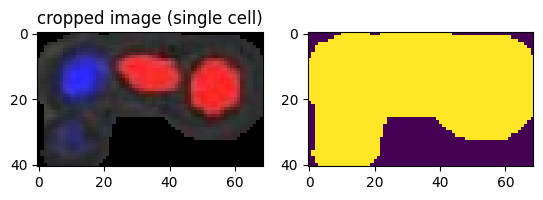

Predicted IoU:  0.9344709515571594
Stability score:  0.9804100394248962


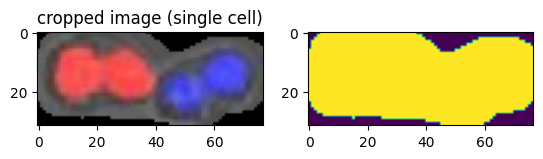

Predicted IoU:  0.9321249127388
Stability score:  0.9704797267913818


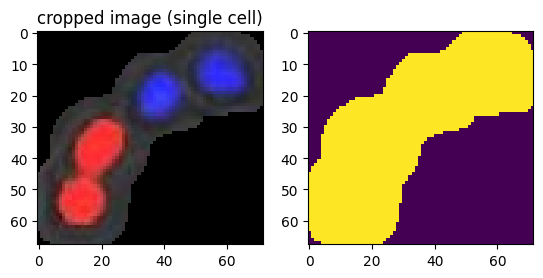

Predicted IoU:  0.8869034051895142
Stability score:  0.9088670015335083


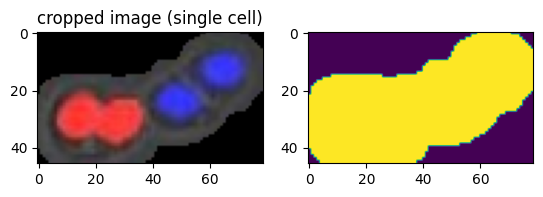

Predicted IoU:  0.8300403952598572
Stability score:  0.9112903475761414
processing cluster...


No of detected cells =  5


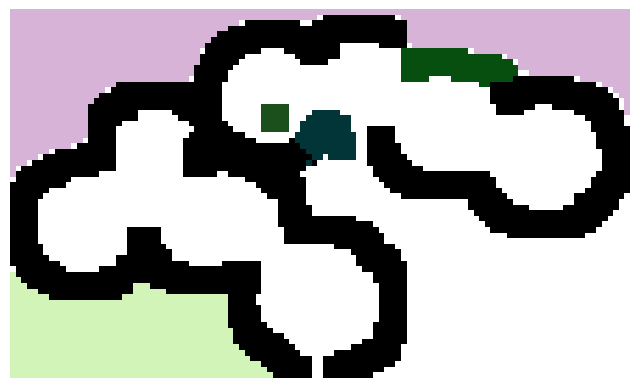

No of detected cells =  11


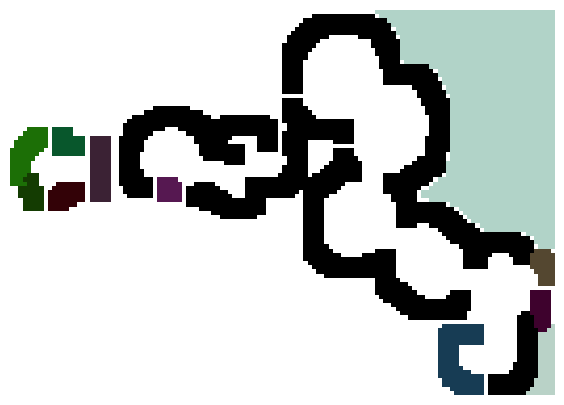

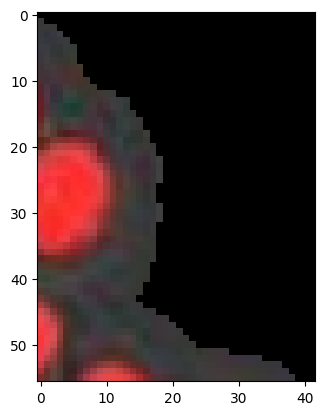

Predicted IoU:  0.9599204063415527
Stability score:  0.8814944624900818


No of detected cells =  8


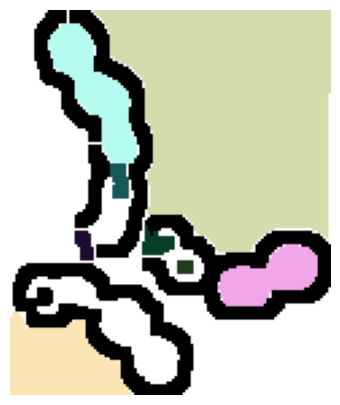

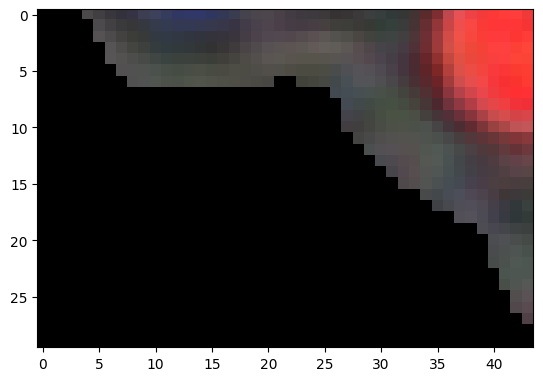

Predicted IoU:  0.9622095823287964
Stability score:  0.9545923471450806


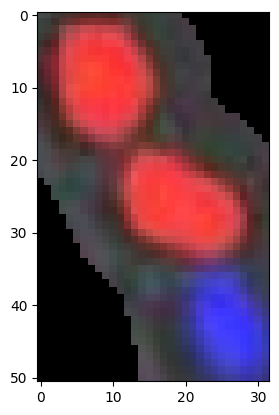

Predicted IoU:  0.8936622142791748
Stability score:  0.9374167919158936


No of detected cells =  24


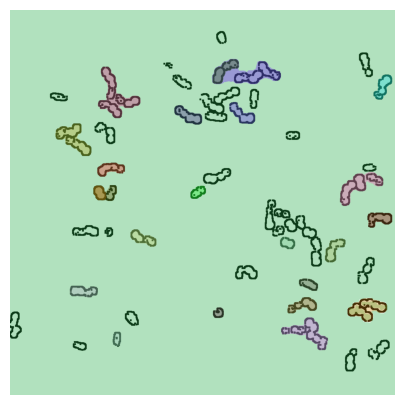

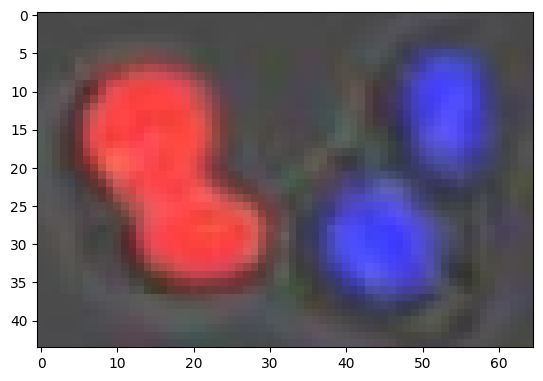

Predicted IoU:  0.9403401017189026
Stability score:  0.9723168611526489


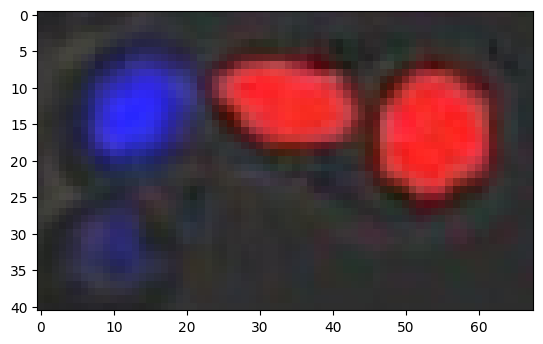

Predicted IoU:  0.9371758103370667
Stability score:  0.9829493165016174


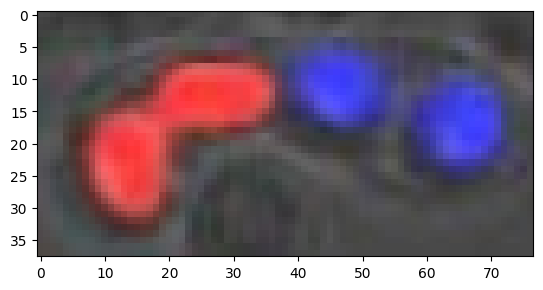

Predicted IoU:  0.9129664897918701
Stability score:  0.9834280014038086


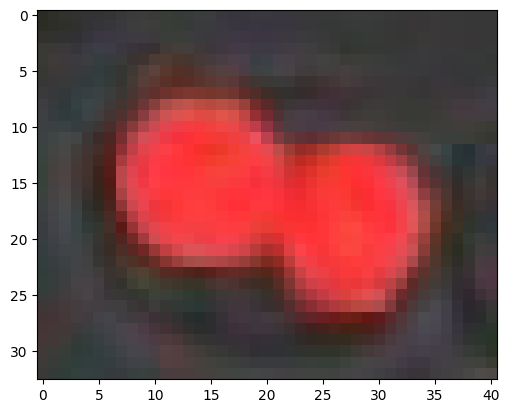

Predicted IoU:  0.9499233365058899
Stability score:  0.988145649433136


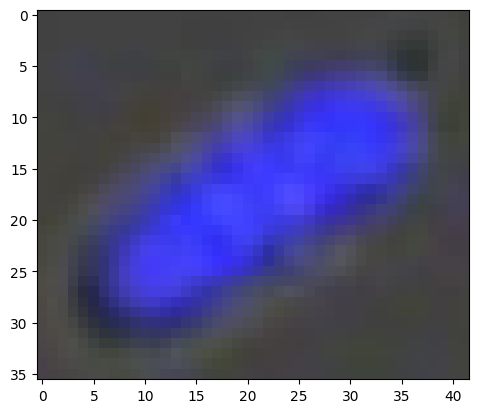

Predicted IoU:  0.9484847784042358
Stability score:  0.9828913807868958


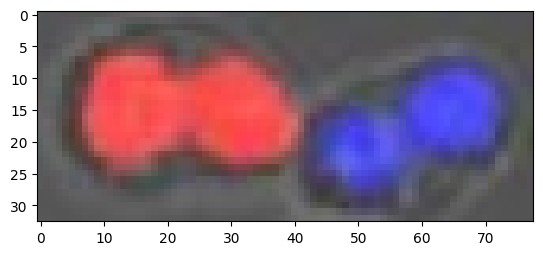

Predicted IoU:  0.9459533095359802
Stability score:  0.9662193655967712


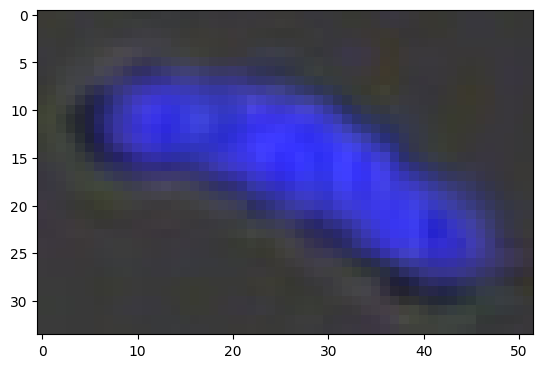

Predicted IoU:  0.9353936910629272
Stability score:  0.9827973246574402


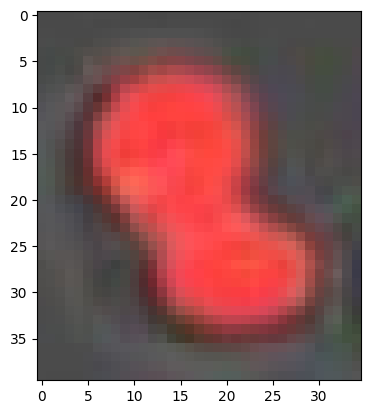

Predicted IoU:  0.8939635753631592
Stability score:  0.9353169202804565


No of detected cells =  13


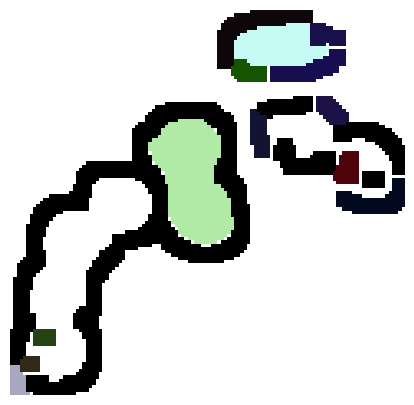

No of detected cells =  11


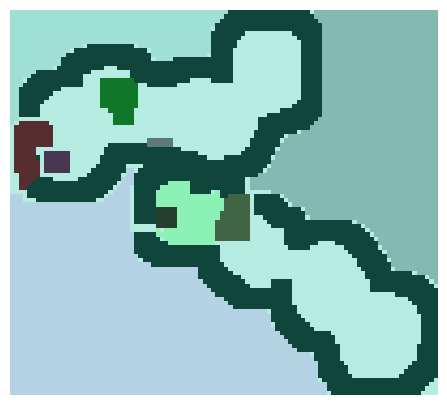

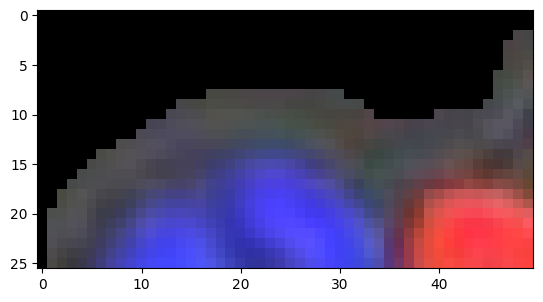

Predicted IoU:  0.9654821157455444
Stability score:  0.9252173900604248


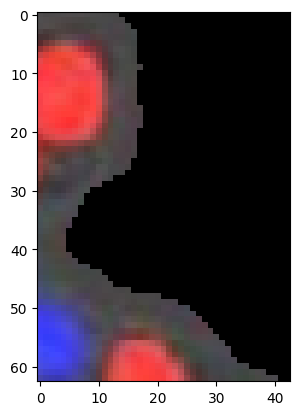

Predicted IoU:  0.9613319635391235
Stability score:  0.9286106824874878


No of detected cells =  16


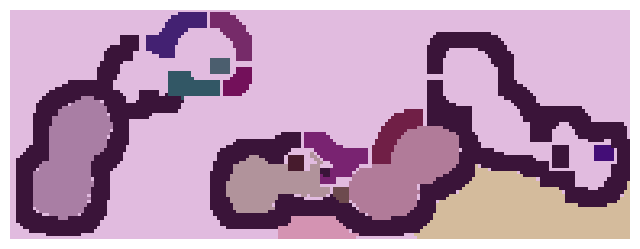

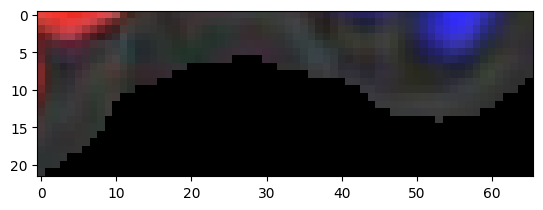

Predicted IoU:  0.8979407548904419
Stability score:  0.9490509629249573


No of detected cells =  8


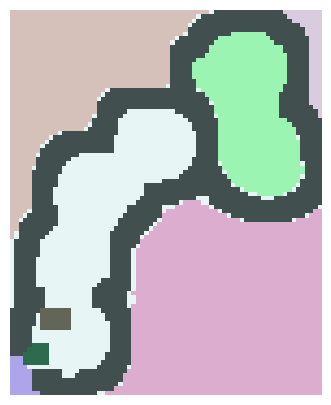

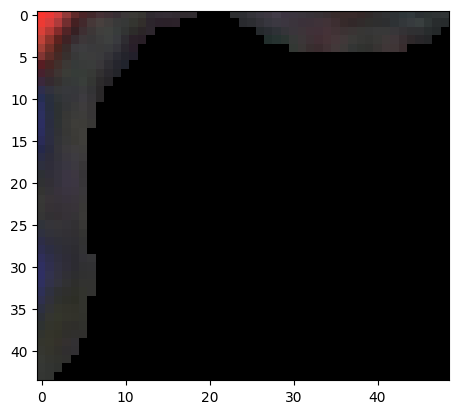

Predicted IoU:  0.9486051797866821
Stability score:  0.925668478012085


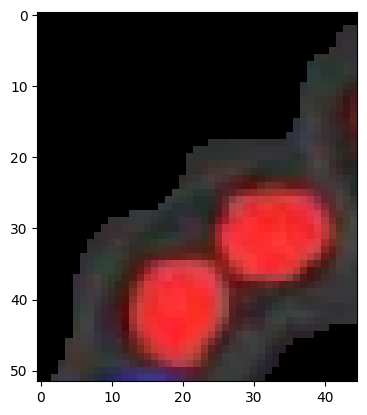

Predicted IoU:  0.9714522361755371
Stability score:  0.901098906993866


No of detected cells =  15


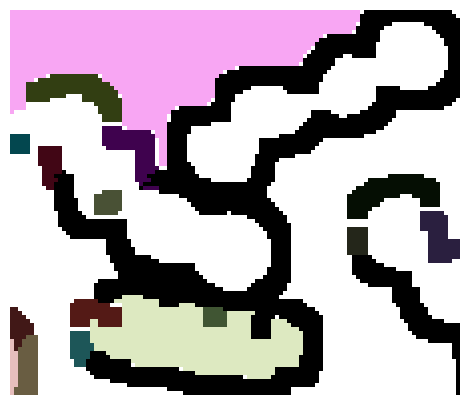

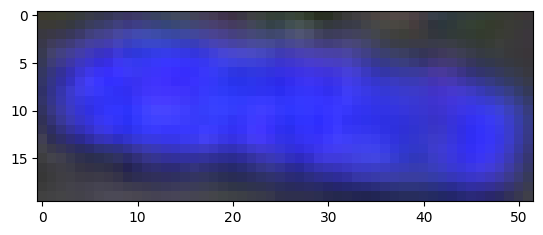

Predicted IoU:  0.8901357650756836
Stability score:  0.9546099305152893


No of detected cells =  11


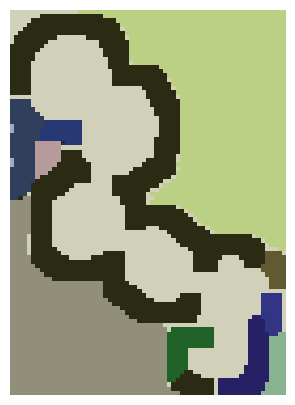

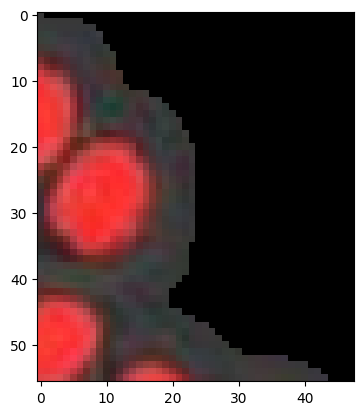

Predicted IoU:  0.969935417175293
Stability score:  0.9366374015808105


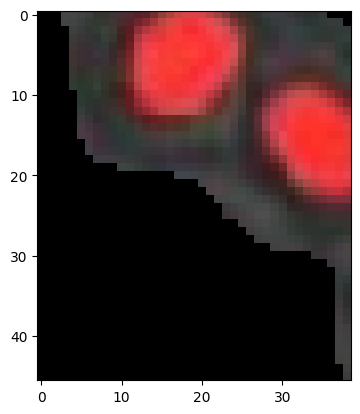

Predicted IoU:  0.9617495536804199
Stability score:  0.9636730551719666
Array of individual cells...


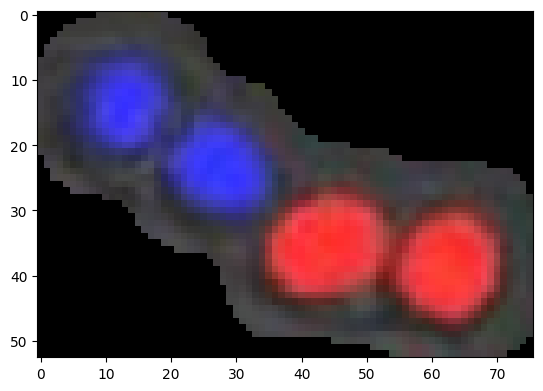

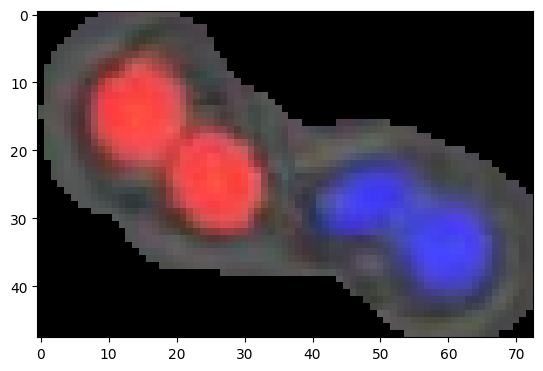

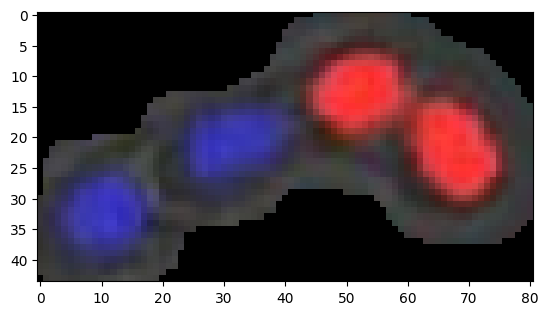

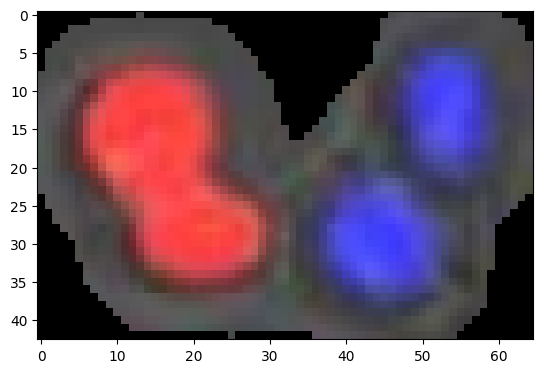

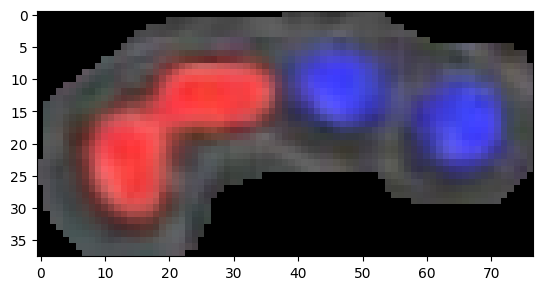

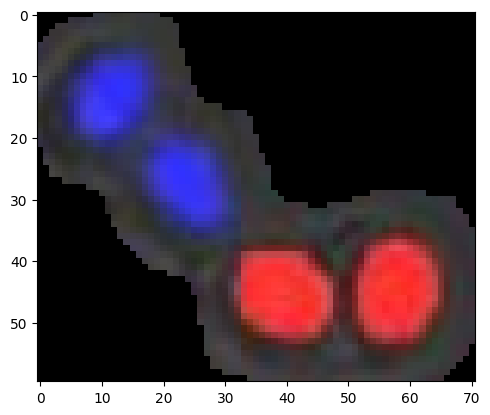

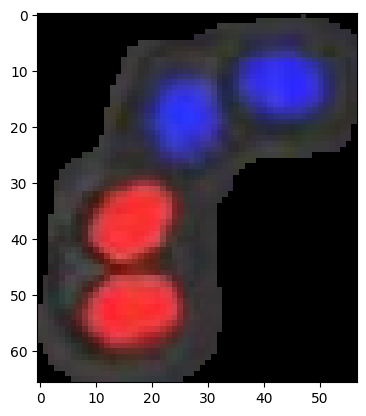

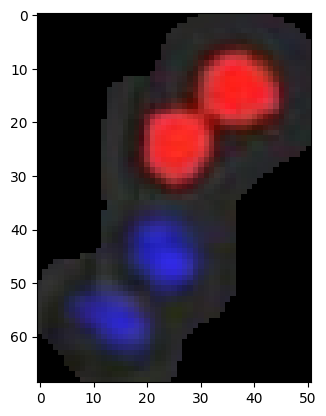

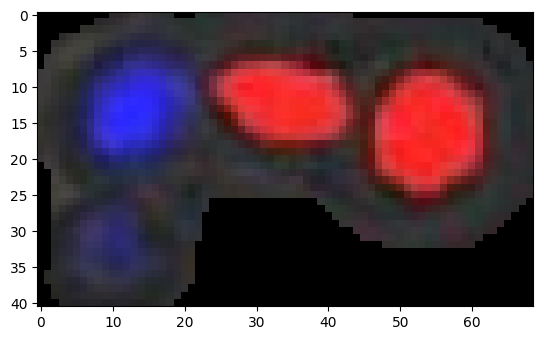

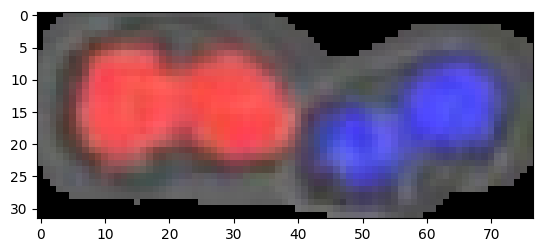

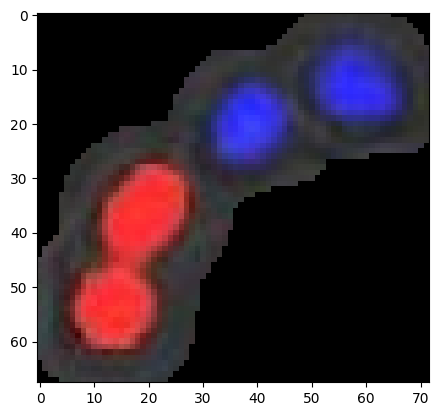

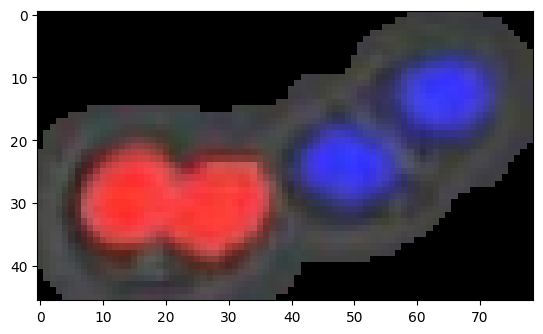

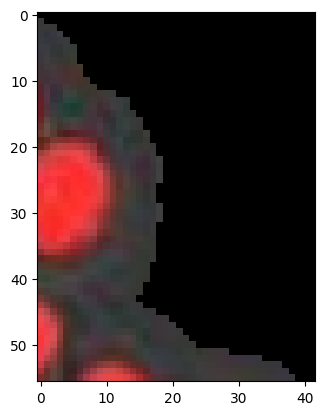

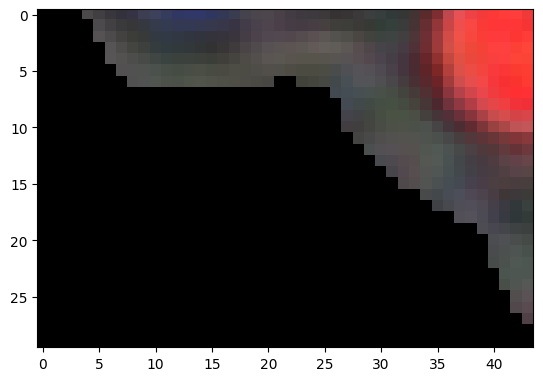

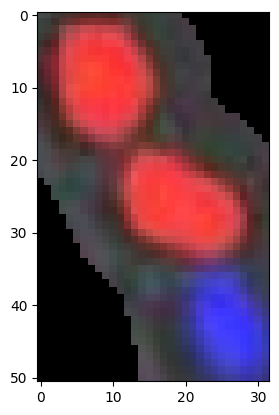

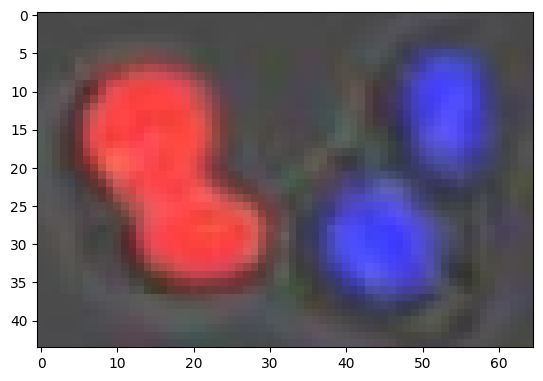

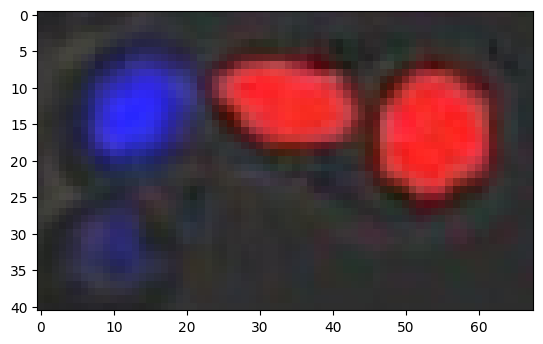

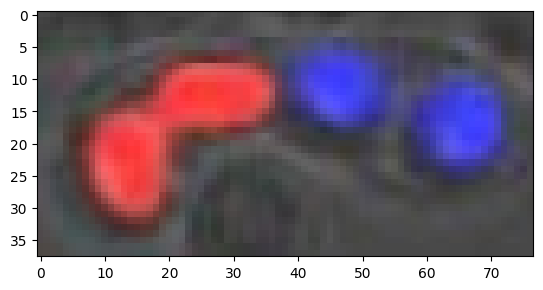

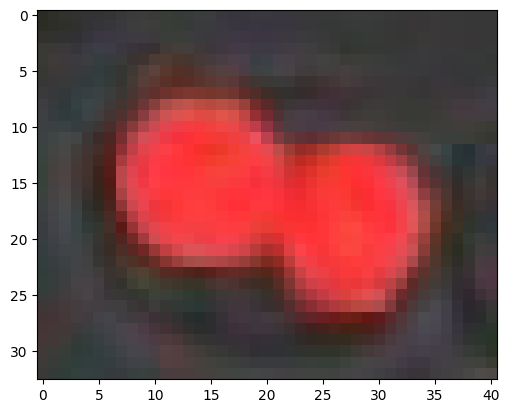

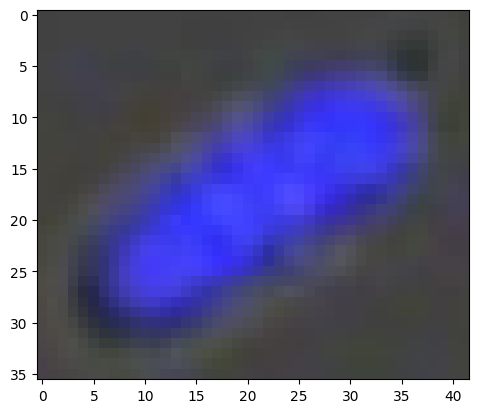

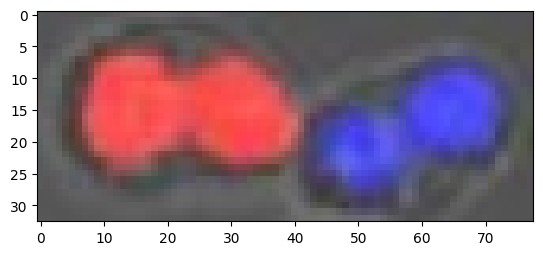

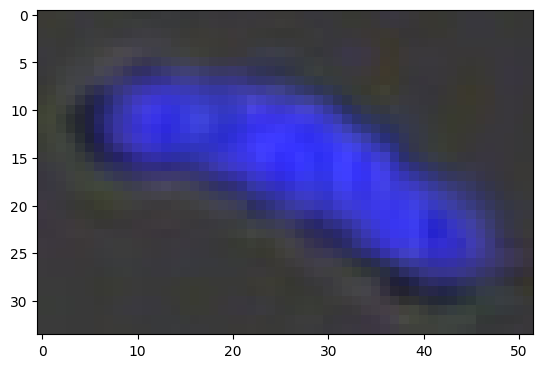

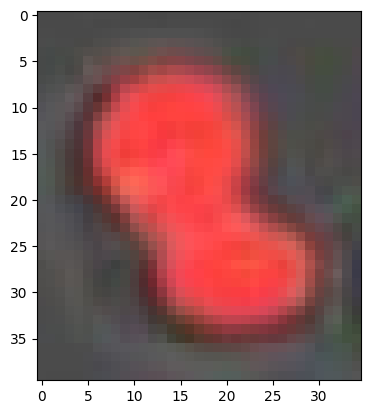

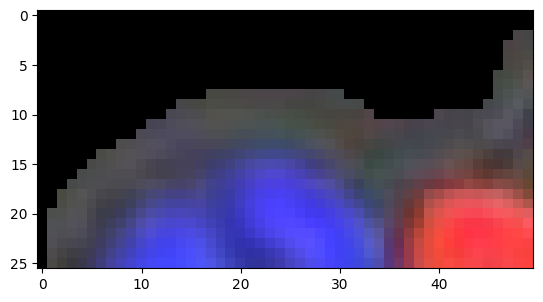

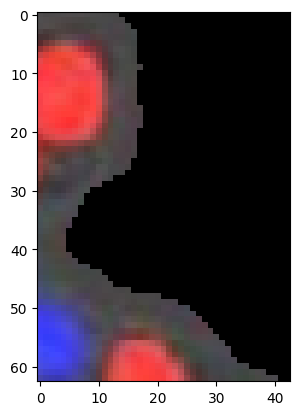

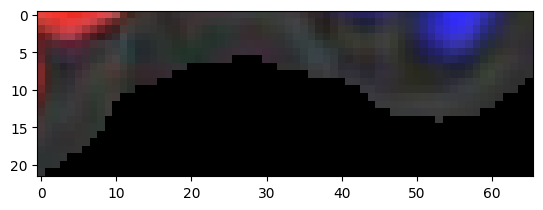

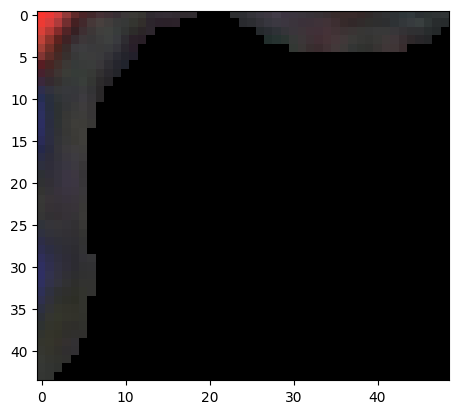

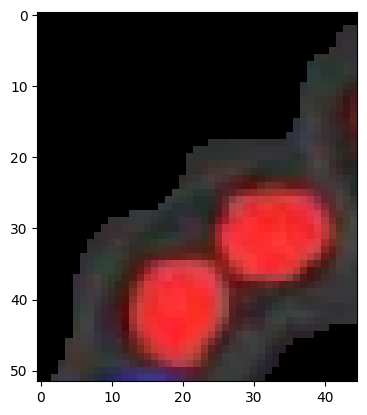

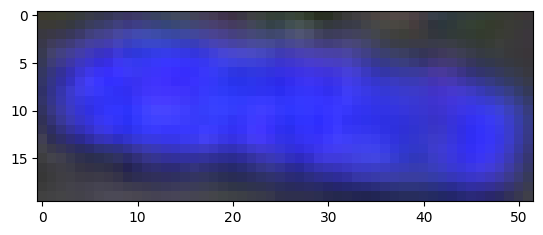

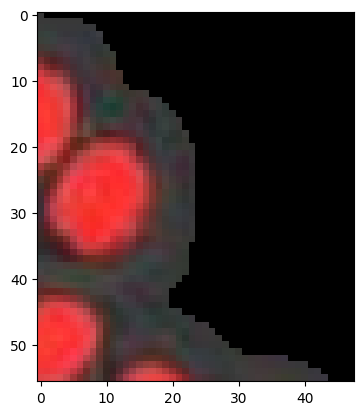

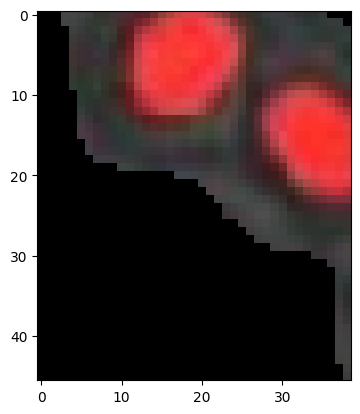

In [11]:

# Initialising program
cell_array = []
cluster_array = []
curr_path = os.getcwd()

IMG_SAVE_PATH_TEST = '/content/drive/MyDrive/segregation_data/Picture_1.jpg'
input_image = PIL.Image.open(IMG_SAVE_PATH_TEST)
input_image = input_image.convert('RGB')
img = np.asarray(input_image, dtype='uint8')

edges = preprocess_image_high_cont(img)
masks = generate_mask(edges, init_mask_gen)
show_mask(img, masks)
cell_array, cluster_edges, cluster_rois = separate_clusters(masks, img, edges)

temp = process_cluster(cluster_edges, cluster_rois)

cell_array += temp

print('Array of individual cells...')
for cell in cell_array:
    plt.imshow(cell)
    plt.show()



In [12]:
import os
curr_working_dir = os.getcwd()
directory = 'segmented_images'
path = os.path.join(curr_working_dir, directory)

if os.path.exists(path) == False:
  try:
      os.mkdir(path)
  except OSError as error:
      print(error)

os.chdir(path)

for i in range(len(cell_array)):
  filename = 'cell_' + str(i) + '.png'
  cv2.imwrite(filename, cell_array[i])

os.listdir(path)



['cell_16.png',
 'cell_13.png',
 'cell_27.png',
 'cell_7.png',
 'cell_28.png',
 'cell_4.png',
 'cell_24.png',
 'cell_19.png',
 'cell_11.png',
 'cell_20.png',
 'cell_25.png',
 'cell_14.png',
 'cell_6.png',
 'cell_15.png',
 'cell_21.png',
 'cell_9.png',
 'cell_10.png',
 'cell_0.png',
 'cell_8.png',
 'cell_12.png',
 'cell_26.png',
 'cell_3.png',
 'cell_1.png',
 'cell_17.png',
 'cell_18.png',
 'cell_30.png',
 'cell_29.png',
 'cell_22.png',
 'cell_2.png',
 'cell_5.png',
 'cell_23.png']

In [13]:
!zip -r /content/sgmt_imgs.zip /content/segmented_images

  adding: content/segmented_images/ (stored 0%)
  adding: content/segmented_images/cell_16.png (stored 0%)
  adding: content/segmented_images/cell_13.png (stored 0%)
  adding: content/segmented_images/cell_27.png (stored 0%)
  adding: content/segmented_images/cell_7.png (stored 0%)
  adding: content/segmented_images/cell_28.png (stored 0%)
  adding: content/segmented_images/cell_4.png (stored 0%)
  adding: content/segmented_images/cell_24.png (stored 0%)
  adding: content/segmented_images/cell_19.png (stored 0%)
  adding: content/segmented_images/cell_11.png (stored 0%)
  adding: content/segmented_images/cell_20.png (stored 0%)
  adding: content/segmented_images/cell_25.png (stored 0%)
  adding: content/segmented_images/cell_14.png (stored 0%)
  adding: content/segmented_images/cell_6.png (stored 0%)
  adding: content/segmented_images/cell_15.png (stored 0%)
  adding: content/segmented_images/cell_21.png (stored 0%)
  adding: content/segmented_images/cell_9.png (stored 0%)
  adding: co